### CNN in HAWQ Training 

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchinfo import summary
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [10]:
from hawq.utils.quantization_utils.quant_modules import QuantConv2d, QuantLinear, QuantAct

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cpu')

#### Define Model in PyTorch 

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,              
            out_channels=16,            
            kernel_size=5,              
            stride=1,                   
            padding=2,
        )
        self.conv2 = nn.Conv2d(
            in_channels=16, 
            out_channels=32, 
            kernel_size=5, 
            stride=1, 
            padding=2
        )
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(1,3)
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.flatten(x)
        output = self.out(x)
        return output  # return x for visualization

In [13]:
model = CNN()
model = model.to(device)
summary(model, input_size=(1,1,28,28)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           416
├─ReLU: 1-2                              [1, 16, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 16, 14, 14]           --
├─Conv2d: 1-4                            [1, 32, 14, 14]           12,832
├─ReLU: 1-5                              [1, 32, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 32, 7, 7]             --
├─Flatten: 1-7                           [1, 1568]                 --
├─Linear: 1-8                            [1, 10]                   15,690
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
Total mult-adds (M): 2.86
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.12
Estimated Total Size (MB): 0.27

#### Define Model in HAWQ

In [14]:
class Q_CNN(nn.Module):
    def __init__(self, model):
        super(Q_CNN, self).__init__()
        
        self.quant_input = QuantAct(activation_bit=12) 
        self.q_relu_1 = QuantAct(activation_bit=8) 
        self.q_relu_2 = QuantAct(activation_bit=8) 
        
        # create quantize Conv2d based on the original layer 
        conv1 = getattr(model, "conv1")
        q_conv1 = QuantConv2d(weight_bit=4, bias_bit=16) 
        q_conv1.set_param(conv1)
        setattr(self, "conv1", q_conv1)

        # create quantize Conv2d based on the original layer 
        conv2 = getattr(model, "conv2")
        q_conv2 = QuantConv2d(weight_bit=4, bias_bit=16) 
        q_conv2.set_param(conv2)
        setattr(self, "conv2", q_conv2)
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(1,3)
        
        # fully connected layer, output 10 classes
        out = getattr(model, "out")
        q_out = QuantLinear(weight_bit=4, bias_bit=4)
        q_out.set_param(out)
        setattr(self, "out", q_out)

    def forward(self, x):

        x, p_sf = self.quant_input(x)

        x, w_sf = self.conv1(x, p_sf)
        x = self.relu(x)
        x, p_sf = self.q_relu_1(x, p_sf, w_sf)
        x = self.max_pool(x)

        x, w_sf = self.conv2(x, p_sf)
        x = self.relu(x)
        x, p_sf = self.q_relu_2(x, p_sf, w_sf)
        x = self.max_pool(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.flatten(x)
        output = self.out(x, p_sf)
        return output  # return x for visualization

In [15]:
model = Q_CNN(model)
model.to(device)

Q_CNN(
  (quant_input): QuantAct(activation_bit=12, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
  (q_relu_1): QuantAct(activation_bit=8, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
  (q_relu_2): QuantAct(activation_bit=8, full_precision_flag=False, quant_mode=symmetric, Act_min: 0.00, Act_max: 0.00)
  (conv1): (QuantConv2d(
    (conv): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  ) weight_bit=4, full_precision_flag=False, quant_mode=symmetric)
  (conv2): (QuantConv2d(
    (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  ) weight_bit=4, full_precision_flag=False, quant_mode=symmetric)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=3)
  (out): (QuantLinear() weight_bit=4, full_precision_flag=False, quantize_fn=symmetric)
)

#### Setup loss and optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

#### Setup data loaders 

In [17]:
root = '../datasets/mnist'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=False)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=False)

train_batch_size = 100
test_batch_size = 1

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=train_batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=test_batch_size,
    shuffle=False
)

#### Train CNN

In [29]:
PATH = 'checkpoints/mnist_q_cnn.pth'
TRAIN = not os.path.isfile(PATH)

if TRAIN:
    os.makedirs('checkpoints', exist_ok=1)
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        correct, total = 0, 0
        for i, data in tqdm.tqdm(enumerate(train_loader, 0), total = len(train_loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (torch.argmax(outputs, dim=1) == labels).type(torch.int8).sum()
            total += len(labels)
            # print statistics
            if i % 100 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:3d}] loss: {running_loss / 2000:.3f}\tacc.: {correct/total:.3f}')
                running_loss = 0.0
                correct, total = 0, 0

    save_model = model.to('cpu')
    torch.save(save_model, PATH)
    print('Finished Training')
else:
    model = torch.load(PATH)

model = model.to(device)

  0%|          | 0/600 [00:00<?, ?it/s]

[1,   1] loss: 0.000	acc.: 0.950
[1, 101] loss: 0.004	acc.: 0.975
[1, 201] loss: 0.004	acc.: 0.976
[1, 301] loss: 0.004	acc.: 0.976
[1, 401] loss: 0.004	acc.: 0.976
[1, 501] loss: 0.004	acc.: 0.977


  0%|          | 0/600 [00:00<?, ?it/s]

[2,   1] loss: 0.000	acc.: 0.970
[2, 101] loss: 0.004	acc.: 0.977
[2, 201] loss: 0.005	acc.: 0.972
[2, 301] loss: 0.004	acc.: 0.979
[2, 401] loss: 0.004	acc.: 0.975
[2, 501] loss: 0.004	acc.: 0.979


  0%|          | 0/600 [00:00<?, ?it/s]

[3,   1] loss: 0.000	acc.: 0.970
[3, 101] loss: 0.004	acc.: 0.975
[3, 201] loss: 0.004	acc.: 0.978
[3, 301] loss: 0.004	acc.: 0.978
[3, 401] loss: 0.004	acc.: 0.973
[3, 501] loss: 0.004	acc.: 0.977


  0%|          | 0/600 [00:00<?, ?it/s]

[4,   1] loss: 0.000	acc.: 0.970
[4, 101] loss: 0.004	acc.: 0.975
[4, 201] loss: 0.004	acc.: 0.976
[4, 301] loss: 0.004	acc.: 0.977
[4, 401] loss: 0.004	acc.: 0.977
[4, 501] loss: 0.004	acc.: 0.975


  0%|          | 0/600 [00:00<?, ?it/s]

[5,   1] loss: 0.000	acc.: 1.000
[5, 101] loss: 0.004	acc.: 0.976
[5, 201] loss: 0.004	acc.: 0.976
[5, 301] loss: 0.004	acc.: 0.974
[5, 401] loss: 0.004	acc.: 0.976
[5, 501] loss: 0.004	acc.: 0.976


  0%|          | 0/600 [00:00<?, ?it/s]

[6,   1] loss: 0.000	acc.: 0.990
[6, 101] loss: 0.004	acc.: 0.975
[6, 201] loss: 0.004	acc.: 0.977
[6, 301] loss: 0.004	acc.: 0.974
[6, 401] loss: 0.004	acc.: 0.976
[6, 501] loss: 0.004	acc.: 0.977


  0%|          | 0/600 [00:00<?, ?it/s]

[7,   1] loss: 0.000	acc.: 0.970
[7, 101] loss: 0.004	acc.: 0.975
[7, 201] loss: 0.004	acc.: 0.978
[7, 301] loss: 0.004	acc.: 0.976
[7, 401] loss: 0.004	acc.: 0.977
[7, 501] loss: 0.004	acc.: 0.975


  0%|          | 0/600 [00:00<?, ?it/s]

[8,   1] loss: 0.000	acc.: 0.950
[8, 101] loss: 0.004	acc.: 0.975
[8, 201] loss: 0.004	acc.: 0.978
[8, 301] loss: 0.004	acc.: 0.975
[8, 401] loss: 0.004	acc.: 0.973
[8, 501] loss: 0.004	acc.: 0.976


  0%|          | 0/600 [00:00<?, ?it/s]

[9,   1] loss: 0.000	acc.: 0.980
[9, 101] loss: 0.004	acc.: 0.977
[9, 201] loss: 0.004	acc.: 0.977
[9, 301] loss: 0.005	acc.: 0.974
[9, 401] loss: 0.004	acc.: 0.974
[9, 501] loss: 0.004	acc.: 0.975


  0%|          | 0/600 [00:00<?, ?it/s]

[10,   1] loss: 0.000	acc.: 0.990
[10, 101] loss: 0.004	acc.: 0.977
[10, 201] loss: 0.004	acc.: 0.977
[10, 301] loss: 0.004	acc.: 0.974
[10, 401] loss: 0.004	acc.: 0.978
[10, 501] loss: 0.004	acc.: 0.973
Finished Training


#### Evaluate

In [19]:
correct = 0
total = 0
y_true = []
y_pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %


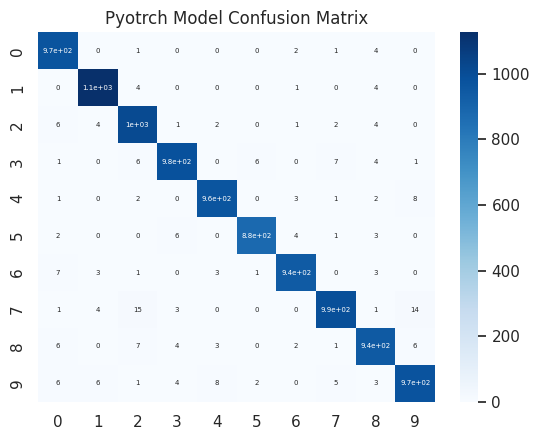

In [20]:
confusion_mtx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_mtx, range(len(confusion_mtx)), range(len(confusion_mtx)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 5}) # font size
plt.title("Pyotrch Model Confusion Matrix")
plt.show()

#### Export to QONNX

In [21]:
from hawq.utils.export import ExportManager

In [22]:
manager = ExportManager(model)
manager.export(torch.randn([1,1,28,28]), "checkpoints/cnn.onnx") 

Exporting model...
Optimizing...


Model saved to: checkpoints/cnn.onnx


#### Visualize QONNX Model

In [23]:
import netron

In [24]:
netron.start("checkpoints/cnn.onnx")

Serving 'checkpoints/cnn.onnx' at http://localhost:8081


('localhost', 8081)

#### Convert Model to HLS 

In [25]:
import hls4ml
from qonnx.core.modelwrapper import ModelWrapper

In [26]:
onnx_model = ModelWrapper("checkpoints/cnn.onnx")

In [27]:
model_name = "checkpoints/cnn.onnx"

config = hls4ml.utils.config_from_onnx_model(model_name, granularity='model')
hls_model = hls4ml.converters.convert_from_onnx_model(model_name, hls_config=config)
hls_model.compile()

Interpreting Model ...
Output layers:  ['Mul_2']
Input shape: [None, 1, 28, 28]
Topology:
Layer name: Quant_0, layer type: Quant, current shape: [[16, 5, 5, 1]]
Layer name: Quant_1, layer type: Quant, current shape: [[32, 5, 5, 16]]
Layer name: Quant_2, layer type: Quant, current shape: [[1568, 10]]
Layer name: Quant_3, layer type: Quant, current shape: [[10]]
Layer name: Transpose_0, layer type: Transpose, current shape: [[1568, 10]]
Layer name: Div_0, layer type: Merge, current shape: [[1, 28, 28, 1]]
Layer name: Conv_0, layer type: Conv, current shape: [[1, 28, 28, 1], [16, 5, 5, 1]]
Layer name: Mul_0, layer type: Merge, current shape: [[1, 28, 28, 16]]
Layer name: Relu_0, layer type: Activation, current shape: [[1, 28, 28, 16]]
Layer name: MaxPool_0, layer type: MaxPooling2D, current shape: [[1, 28, 28, 16]]
Layer name: Div_1, layer type: Merge, current shape: [[1, 14, 14, 16]]
Layer name: Conv_1, layer type: Conv, current shape: [[1, 14, 14, 16], [32, 5, 5, 16]]
Layer name: Mul_1,